In [2]:
import healpy as hp
import numpy as n_p
import matplotlib.pyplot as plt
import os
from os.path import join as opj

from plancklens import utils

from delensalot.core import cachers

#from lenspyx.remapping import utils_geom as utils_scarf
#from delensalot.core.secondaries import secondaries

%reload_ext autoreload
%autoreload 2


In [3]:
import os
import numpy as np

import logging
log = logging.getLogger(__name__)
from logdecorator import log_on_start, log_on_end

alm2rlm = lambda x : x.copy()
rlm2alm = lambda x : x.copy()

#TODO this looks like a 'query' class to me. May be refactored.
class rec:
    """Static methods to reach for iterated lensing maps etc


    """

    @staticmethod
    def maxiterdone(lib_dir):
        lib_dir = os.path.abspath(lib_dir)
        itr = -2
        isdone = True
        while isdone:
            itr += 1
            isdone = rec.is_iter_done(lib_dir, itr + 1)
        return itr

    @staticmethod
    def load_plms(lib_dir, itrs):
        """Loads plms for the requested itrs"""
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        itmax = np.max(itrs)
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
        rlm = alm2rlm(cacher.load(os.path.join(lib_dir, 'phi_plm_it000')))
        ret = [] if 0 not in itrs else [rlm2alm(rlm)]
        for i in range(itmax):
            if cacher.is_cached(sk_fname(i)):
                rlm += cacher.load(sk_fname(i))
                if (i + 1) in itrs:
                    ret.append(rlm2alm(rlm))
            else:
                log.info("*** Could only build up to itr number %s"%i)
                return ret
        return ret

    @staticmethod
    def load_elm(lib_dir, itr):
        """Load delensing E-map at iteration 'itr'

        """
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        e_fname = os.path.join(lib_dir, 'wflms', 'wflm_%s_it%s' % ('p', itr))
        assert cacher.is_cached(e_fname), 'cant load ' + e_fname
        return cacher.load(e_fname)

    @staticmethod
    def is_iter_done(lib_dir, itr):
        """Returns True if the iteration 'itr' has been performed already and False if not

        """
        lib_dir = os.path.abspath(lib_dir)
        if not os.path.exists(lib_dir): return False
        cacher = cachers.cacher_npy(lib_dir)
        if itr <= 0:
            return cacher.is_cached('%s_plm_it000' % ({'p': 'phi', 'o': 'om'}['p']))
        sk_fname = lambda k: os.path.join(lib_dir, 'hessian', 'rlm_sn_%s_%s' % (k, 'p'))
        return cacher.is_cached(sk_fname(itr - 1))

    @staticmethod
    def load_grad(lib_dir, itr):
        #FIXME: load gradient at zero
        assert 0, 'fix gradient load at 0'
        lib_dir = os.path.abspath(lib_dir)
        cacher = cachers.cacher_npy(lib_dir)
        yk_fname = lambda k: os.path.join(lib_dir, 'hessian','rlm_yn_%s_%s' % (k, 'p'))
        rlm = alm2rlm(load_gradient(0, 'p'))
        for i in range(itr):
            rlm += cacher.load(yk_fname(i))
        return rlm2alm(rlm)

In [4]:
cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))

In [5]:
cmbversion = "birefringence_only_v1"
scratch = os.environ["SCRATCH"]
scratch = f"{scratch}/{cmbversion}/"

In [6]:
dir = f"{scratch}/simswalpha/"

alpha_both = hp.read_alm(dir+"sim_0000_alpha_lm.fits").astype(np.complex128)
phi_both = hp.read_alm(dir+"sim_0000_plm.fits").astype(np.complex128)
elm_both = hp.read_alm(dir+"sim_0000_elm.fits").astype(np.complex128)
blm_both = hp.read_alm(dir+"sim_0000_blm.fits").astype(np.complex128)

In [8]:
from lenspyx.remapping import utils_geom as utils_scarf
from delensalot.core.secondaries import secondaries
lmax_qlm, mmax_qlm = 5120, 5120
tr = 128
ninv_geom = utils_scarf.Geom.get_thingauss_geometry(lmax_qlm + 100, 2)

In [ ]:
alm0 = np.load("/pscratch/sd/o/omard/birefringence_only_v1recs/p_p_sim0000birefringence_only_v1/phi_plm_it000.npy")

In [ ]:
RotationOp = secondaries.Rotation(name = "a", lmax = lmax_qlm, mmax = mmax_qlm, sht_tr = tr)
alpha_map = ninv_geom.synthesis(alpha_both, spin = 0, lmax = lmax_qlm, mmax = mmax_qlm, nthreads = tr).squeeze()
RotationOp.set_field(alpha_map)

In [ ]:
lmax_in = hp.Alm.getlmax(elm_both.size)

In [ ]:
eblm = np.array([elm_both, blm_both])

In [127]:
elm_unlensed = hp.synalm(cls_unl["ee"], lmax = hp.Alm.getlmax(elm_both.size))

In [128]:
blm_unlensed = np.zeros_like(elm_unlensed)

eblm_unlensed = np.array([elm_unlensed, blm_unlensed])

In [129]:
fwd = RotationOp(eblm_unlensed, backwards = False, derivative = False, q_pbgeom = ninv_geom, lmax_in = lmax_in, lmax_out = lmax_qlm, mmax_out = mmax_qlm, out_sht_mode = "STANDARD", apply_weights = True)

In [130]:
elm_out, blm_out = fwd
lmax_in = hp.Alm.getlmax(elm_out.size)

In [188]:
alpha_map = ninv_geom.synthesis(alm0, spin = 0, lmax = lmax_qlm, mmax = mmax_qlm, nthreads = tr).squeeze()
RotationOp.set_field(-alpha_map)

In [132]:
result = RotationOp(fwd, backwards = True, derivative = False, q_pbgeom = ninv_geom, lmax_in = lmax_in, lmax_out = lmax_qlm, mmax_out = mmax_qlm, out_sht_mode = "STANDARD", apply_weights = True)

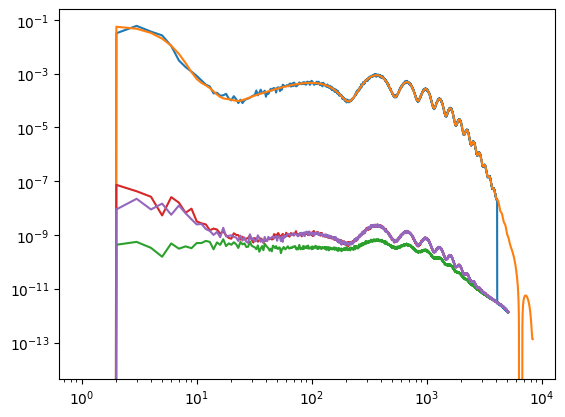

In [246]:
plt.loglog(hp.alm2cl(result[0]))

#plt.loglog(hp.alm2cl(elm_both))

#plt.loglog(hp.alm2cl(elm_out))

plt.plot(cls_unl["ee"])

plt.loglog(hp.alm2cl(result[1]))

plt.loglog(hp.alm2cl(blm_both))
plt.plot(hp.alm2cl(blm_out))
#plt.plot(cls_unl["bb"])

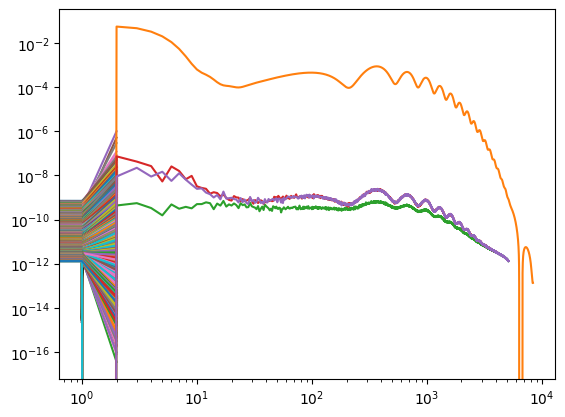

In [245]:
plt.loglog(hp.alm2cl(result))

#plt.loglog(hp.alm2cl(elm_both))

#plt.loglog(hp.alm2cl(elm_out))

plt.plot(cls_unl["ee"])

plt.loglog(hp.alm2cl(result[1]))

plt.loglog(hp.alm2cl(blm_both))
plt.plot(hp.alm2cl(blm_out))
#plt.plot(cls_unl["bb"])

In [8]:
lmax = hp.Alm.getlmax(phi_both.size)
mmax = lmax

In [16]:
nside = 2048
ninv_geom = utils_scarf.Geom.get_healpix_geometry(nside)
ninv_geom = utils_scarf.Geom.get_thingauss_geometry(5120+100, 2)

In [9]:
alpha_map = ninv_geom.synthesis(phi_both, spin = 0, lmax = lmax, mmax = mmax, nthreads = 32).squeeze()

In [17]:
ninv_geom.synthesis(phi_both, spin = 0, lmax = lmax, mmax = mmax, nthreads = 32).shape

(1, 36310030)

In [18]:
ninv_geom.synthesis(phi_both, spin = 0, lmax = lmax+20, mmax = lmax+20, nthreads = 32).shape

(1, 36310030)

## Compare reconstruction of $\phi$ from joint module vs baseline module

In [9]:
from plancklens import utils

In [10]:
cmbversion = "birefringence_only_v3"
scratch = os.environ["SCRATCH"]
scratch = f"{scratch}/{cmbversion}/"

dir = f"{scratch}/simswalpha/"
alpha_both = hp.read_alm(dir+"sim_0000_alpha_lm.fits").astype(np.complex128)

In [11]:
directory_reconstruction = "/pscratch/sd/o/omard/birefringence_only_v3recs/p_p_sim0000birefringence_only_v3/"

In [12]:
itrs = [0, 1, 2, 3, 4, 5, 6, 7, 9]
recs = rec()
plms = recs.load_plms(directory_reconstruction, itrs = itrs)

In [13]:
lmax = hp.Alm.getlmax(plms[0].size)
lmax_both = hp.Alm.getlmax(alpha_both.size)
alpha_both = utils.alm_copy(alpha_both, lmax = lmax)
lmax, lmax_both

(5120, 6024)

In [116]:
def cross_corr_coeff(a, b, base = 0, color = None, plot = True, ax = None):
    xcorr = hp.alm2cl(a, b)**2/(hp.alm2cl(a, a)*hp.alm2cl(b, b))
    if plot:
        if ax is None:
            plt.plot(xcorr-base, color = color)
        else:
            ax.plot(xcorr-base, color = color)
    return xcorr

/tmp/ipykernel_796342/1319169524.py:2: RuntimeWarning: invalid value encountered in divide
  xcorr = hp.alm2cl(a, b)**2/(hp.alm2cl(a, a)*hp.alm2cl(b, b))


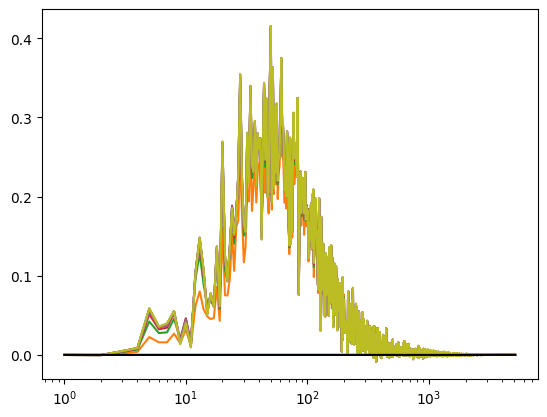

In [15]:
for idx, itr in enumerate(itrs):
    if idx == 0:
        xcorr = cross_corr_coeff(plms[idx], alpha_both, plot = False)

    cross_corr_coeff(plms[idx], alpha_both, base = xcorr)


cross_corr_coeff(alpha_both, alpha_both, base = 1, color = "black")
#plt.loglog(-hp.alm2cl(plms[0], -alpha_both))
#plt.loglog(-hp.alm2cl(plms[0]-diff, alpha_both))
plt.xscale("log")

/tmp/ipykernel_796342/1319169524.py:2: RuntimeWarning: invalid value encountered in divide
  xcorr = hp.alm2cl(a, b)**2/(hp.alm2cl(a, a)*hp.alm2cl(b, b))


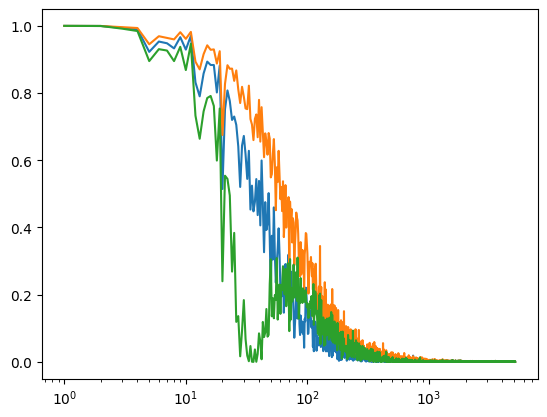

In [16]:
cross_corr_coeff(plms[0], alpha_both)
cross_corr_coeff(plms[1], alpha_both)

diff = plms[1]-plms[0]
cross_corr_coeff(plms[0]-diff, alpha_both)

plt.xscale("log")

In [17]:
itrs = [0, 1, 2, 3]
recs = rec()
directory_reconstruction = "/pscratch/sd/o/omard/birefringence_lensing_v5recs/p_p_sim0000birefringence_lensing__v6/"
plms_1 = recs.load_plms(directory_reconstruction, itrs = itrs)

directory_reconstruction = "/pscratch/sd/o/omard/birefringence_lensing_v5recs/p_p_sim0000birefringence_lensing__v9/"
plms_2 = recs.load_plms(directory_reconstruction, itrs = itrs)

In [18]:
ind = -1
print(np.allclose(plms_1[ind], plms_2[ind]))
(hp.alm2cl(plms_2[ind])/hp.alm2cl(plms_1[ind]))#*100

False


/tmp/ipykernel_796342/846858357.py:3: RuntimeWarning: invalid value encountered in divide
  (hp.alm2cl(plms_2[ind])/hp.alm2cl(plms_1[ind]))#*100


array([       nan, 0.94686141, 1.0000329 , ..., 1.00000093, 1.0000007 ,
       1.00000178])

In [19]:
dirpo = "/pscratch/sd/o/omard/birefringence_lensing_v5recs/p_p_sim0000birefringence_lensing__v10/"

In [73]:
inv = np.load("pp_h0s_matrix.npy")
hh_h0 = np.load("hh_h0.npy")

In [74]:
inv[:, 0, 0]/hh_h0

/tmp/ipykernel_796342/887570706.py:1: RuntimeWarning: invalid value encountered in divide
  inv[:, 0, 0]/hh_h0


array([nan, nan,  1., ...,  1.,  1.,  1.])

In [75]:
w1 = np.load("/pscratch/sd/o/omard/bire_phirecs/p_p_sim0000phi_omega_joint/wflms/wflm_p_it0.npy")
w2 = np.load("/pscratch/sd/o/omard/bire_phirecs/p_p_sim0000phi_joint/wflms/wflm_p_it0.npy")

In [76]:
hp.alm2cl(w1)/hp.alm2cl(w2)

/tmp/ipykernel_796342/3743271006.py:1: RuntimeWarning: invalid value encountered in divide
  hp.alm2cl(w1)/hp.alm2cl(w2)


array([       nan,        nan, 1.00001579, ..., 0.99244981, 0.99247209,
       0.9907711 ])

In [110]:
cmbversion = "bire_phi"
cmbversion = "phi_alpha"


scratch = os.environ["SCRATCH"]
scratch = f"{scratch}/{cmbversion}/"


dir = f"{scratch}/simswalpha/"
phi = hp.read_alm(dir+"sim_0000_plm.fits").astype(np.complex128)
phi = utils.alm_copy(phi, lmax = 5120)

alpha = hp.read_alm(dir+"sim_0000_alpha_lm.fits").astype(np.complex128)
alpha = utils.alm_copy(alpha, lmax = 5120)

In [118]:
#version = "bire_phi_v1"
#version = "phi_v1"
#version = "phi_joint"
version = "phi_omega_alpha_joint"
its_folder = f"/pscratch/sd/o/omard/{cmbversion}recs/p_p_sim0000{version}/"

itrs = [0, 1, 2, 3, 4]
recs = rec()
directory_reconstruction = its_folder
plms = recs.load_plms(directory_reconstruction, itrs = itrs)

In [123]:
alpha_index = 0
phi_index = 1
omega_index = 2

indices = [alpha_index, phi_index, omega_index]

names = ["alpha", "phi", "omega"]

fields = [alpha, phi, alpha]

ncomps = len(indices)

/tmp/ipykernel_796342/1331402201.py:2: RuntimeWarning: invalid value encountered in divide
  xcorr = hp.alm2cl(a, b)**2/(hp.alm2cl(a, a)*hp.alm2cl(b, b))


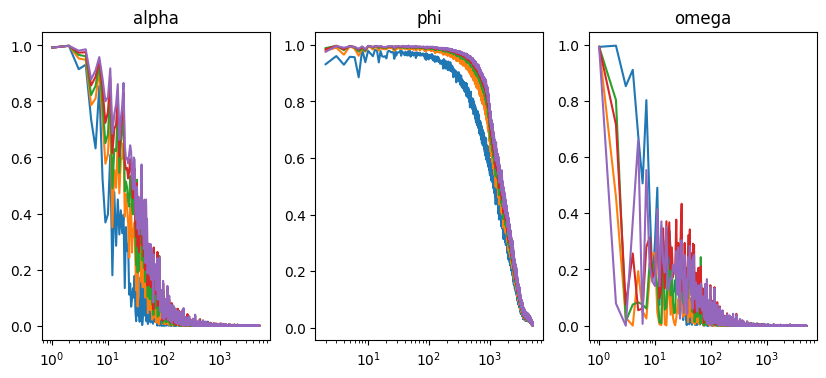

In [124]:
fig, ax = plt.subplots(nrows = 1, ncols = ncomps, figsize = (10, 4))

for index in indices:
    field = fields[index]
    ax[index].set_title(names[index])
    for idx, itr in enumerate(itrs):
        p = np.split(plms[idx], ncomps)[index] if (plms[idx].size % ncomps == 0) else plms[idx]
        if idx == 0:
            xcorr = cross_corr_coeff(p, field, plot = False)

        cross_corr_coeff(p, field, base = 0, ax = ax[index])

    ax[index].set_xscale("log")

#cross_corr_coeff(alpha_both, alpha_both, base = 1, color = "black")
#plt.loglog(-hp.alm2cl(plms[0], -alpha_both))
#plt.loglog(-hp.alm2cl(plms[0]-diff, alpha_both))


In [97]:
g1 = np.load("/pscratch/sd/o/omard/phirecs/p_p_sim0000phi_omega_joint_None/plm_gradplik_it000.npy")
g2 = np.load("/pscratch/sd/o/omard/bire_phirecs/p_p_sim0000phi_joint/plm_gradplik_it000.npy")

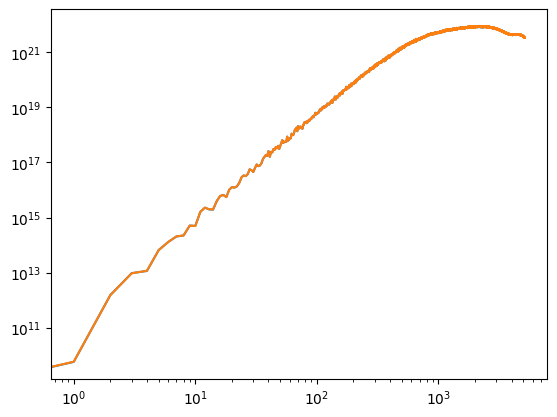

In [98]:
plt.loglog(hp.alm2cl(np.split(g1, 2)[0]))
plt.loglog(hp.alm2cl(g2))

In [ ]:
Call p
Call o
Call p

/tmp/ipykernel_796342/2563915694.py:4: RuntimeWarning: invalid value encountered in divide
  plt.loglog(hp.alm2cl(np.split(g1, 2)[0])/hp.alm2cl(g2))


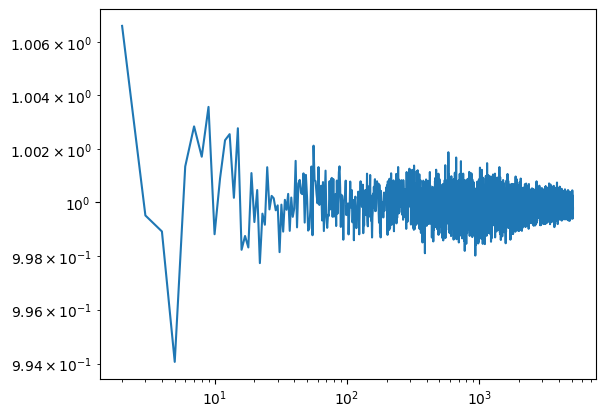

In [91]:
g1 = np.load("/pscratch/sd/o/omard/phirecs/p_p_sim0000phi_omega_joint_tol_8/phi_plm_it000.npy")
g2 = np.load("/pscratch/sd/o/omard/bire_phirecs/p_p_sim0000phi_joint/phi_plm_it000.npy")

plt.loglog(hp.alm2cl(np.split(g1, 2)[0])/hp.alm2cl(g2))